In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt

In [2]:
trainset = torchvision.datasets.MNIST("./data/", train = True, transform=transforms.ToTensor(), download = False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.MNIST("./data/", train = False, transform=transforms.ToTensor(), download = False)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=True)

In [3]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return (self.layers(x.view(-1,784)))

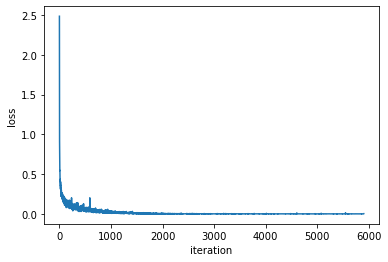

In [4]:
net=NN()
n_epochs=50
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss = torch.nn.CrossEntropyLoss()
losses=[]
for epoch in range(n_epochs):
    print("Epoch: ", epoch, '/', n_epochs, end='\r')
    net.train()
    for x, y in trainloader:
        out=net(x)
        l=loss(out, y)
        losses.append(l)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    scheduler.step()
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [5]:
net.eval()
correct=0
with torch.no_grad():
    for x, y in trainloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on training set: ", correct/len(trainset))

correct=0
with torch.no_grad():
    for x, y in testloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on test set: ", correct/len(testset))

Accuracy on training set:  1.0
Accuracy on test set:  0.9767


In [6]:
permuted_index = torch.randperm(len(trainset.targets))
trainset.targets = trainset.targets[permuted_index]
trainloader_permuted = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

In [7]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,10)
        )
    def forward(self, x):
        return (self.layers(x.view(-1,784)))

Accuracy on train set:  0.1323
tensor(2.3723, grad_fn=<NllLossBackward>)
Accuracy on train set:  0.15223333333333333
Accuracy on train set:  0.16558333333333333
Accuracy on train set:  0.17433333333333334
Accuracy on train set:  0.18933333333333333
Accuracy on train set:  0.213
Accuracy on train set:  0.23548333333333332
Accuracy on train set:  0.2687833333333333
Accuracy on train set:  0.2926166666666667
Accuracy on train set:  0.3274
Accuracy on train set:  0.38145
tensor(2.0394, grad_fn=<NllLossBackward>)
Accuracy on train set:  0.4196166666666667
Accuracy on train set:  0.46486666666666665
Accuracy on train set:  0.5106
Accuracy on train set:  0.5623833333333333
Accuracy on train set:  0.6215166666666667
Accuracy on train set:  0.6757833333333333
Accuracy on train set:  0.71835
Accuracy on train set:  0.7566
Accuracy on train set:  0.7934333333333333
Accuracy on train set:  0.8255666666666667
tensor(1.0092, grad_fn=<NllLossBackward>)
Accuracy on train set:  0.8633833333333333
Accur

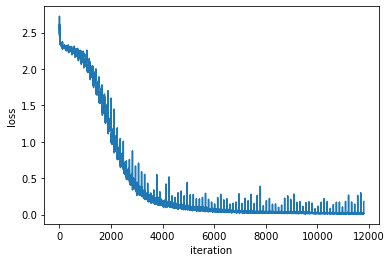

In [8]:
net=NN()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
loss = torch.nn.CrossEntropyLoss()
losses=[]
for epoch in range(100):
    print("Epoch: ", epoch, '/', 100, end='\r')
    net.train()
    for x, y in trainloader:
        out=net(x)
        l=loss(out, y)
        losses.append(l)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    scheduler.step()
    net.eval()
    correct=0
    with torch.no_grad():
        for x, y in trainloader:
            out=net(x)
            correct+=(torch.argmax(out, axis=1)==y).sum().item()
    print("Accuracy on train set: ", correct/len(trainset))
    if epoch%10==0:
        print(l)
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [9]:
net.eval()
correct=0
with torch.no_grad():
    for x, y in trainloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on training set (with permuted labels): ", correct/len(trainset))

correct=0
with torch.no_grad():
    for x, y in testloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on test set (with original labels): ", correct/len(testset))

Accuracy on training set (with permuted labels):  0.9999166666666667
Accuracy on test set (with original labels):  0.0964
